# Estimation of level sets with BoTorch

following the entry level tutorial here https://botorch.org but I have also browsed extensively along Bite-sized and full-loop tutorials

## 1D example Ackley function

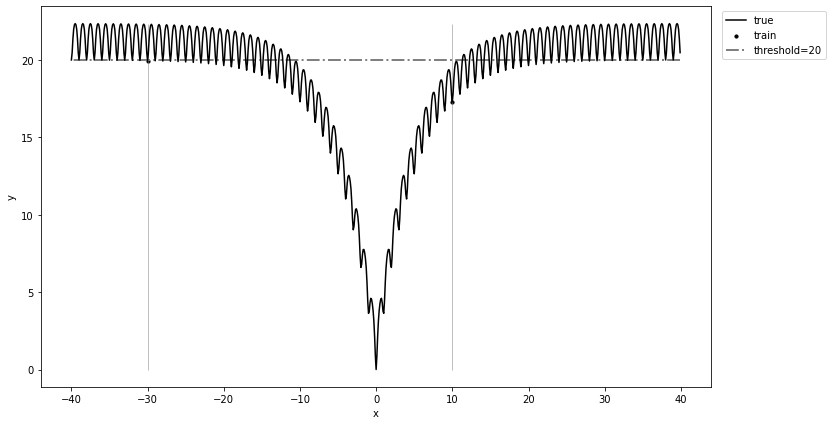

In [1]:
%load_ext autoreload
%autoreload 2

from torch import Tensor
import torch
from botorch.test_functions.synthetic import Ackley

def f(x: Tensor):
    ackley = Ackley(dim = 1).evaluate_true
    return ackley(x)

#threshold
t = 20

#generate truth data
true_x = torch.arange(-40,40, 0.1).double().view(-1,1)
true_y = f(true_x).double().view(-1,1)

#generate std training data
train_x = torch.Tensor([[-30], [10]]).double().view(-1,1)
train_y = f(train_x).double().view(-1,1)
#train_y_std = standardize(train_y).double()

from lib import plotting
plotting.make_plot(true_x, true_y, train_x, train_y, t, f)

In [2]:
#helper function
from botorch.models import FixedNoiseGP
from botorch import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
def init_model(train_x: Tensor , train_y: Tensor, state_dict=None):
    noise = torch.full_like(train_y, 0.)
    gp = FixedNoiseGP(train_x, train_y, noise);
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp);
    if state_dict is not None:
        gp.load_state_dict(state_dict)
    return gp, mll
gp, mll = init_model(train_x, train_y)

In [3]:
from lib.acquisition import MaximumEntropySearch_LevelSetEstimation
from botorch.optim import optimize_acqf
import numpy as np

bounds = torch.stack([-40*torch.ones(1), 40*torch.ones(1)]).double()
threshold = torch.Tensor([t]) 
threshold.requires_grad=True
N_TRIALS = 0
N_Q = 1
N_RESTART = 1
N_SAMPLES = 500
save_new_x = []

for experiment in range(0): #repeated experiments to get error bars
    save_new_x = [] 
    #generate std training data
    train_x = torch.Tensor([[-30], [10]]).double().view(-1,1)
    train_y = f(train_x).double().view(-1,1)
    gp, mll = init_model(train_x, train_y)   
    
    for i in range(1, N_TRIALS+1): #one Active Learning experiment
        fit_gpytorch_model(mll)
        
        #find suggestions
        MES_LSE = MaximumEntropySearch_LevelSetEstimation(gp, threshold=threshold)
        candidate, acq_candidate = optimize_acqf(
            MES_LSE, bounds=bounds, q=N_Q, num_restarts=N_RESTART, raw_samples=N_SAMPLES,
        )
        print(f"Suggestion iteration {i}: x_new = {candidate} with acq = {acq_candidate.item()}")
        save_new_x.append(candidate[0].item())
        
        #update training set
        train_x = torch.vstack([train_x, candidate[0]])
        train_y = torch.vstack([train_y, f(candidate[0])])
        
        #update fit
        gp, mll = init_model(train_x, train_y, gp.state_dict())    
        
        #save acq values for plotting
        acq_X = MES_LSE(true_x.view(-1,1,1))
        
        #plot fit
        mean = gp.posterior(true_x).mean.detach().numpy().flatten()
        std = np.sqrt(gp.posterior(true_x).variance.detach().numpy().flatten())
        np.save(f"./results/new_x_ackley_1d_experiment_{experiment}.npy",save_new_x)
        
        #make_plot(true_x, true_y, train_x, train_y, t, f, mean=mean, std=std, new_x = candidate, acq=acq_X)
        #plt.savefig(f"images/ackley_1D_{i}.png")
        #plt.show()

In [9]:
#prepare histogram data of selected xs
import glob
import os
import numpy as np

npFiles = [file for file in glob.glob("/home/irina/Documents/PROJECTS/prototypes/results/*.npy")]

array=np.zeros((20,250))
for i, file in enumerate(npFiles):
    array[i] = np.load(file)
    array[i] = np.sort(array[i])
    
#get mean and std of counts
count = np.zeros((20,10))
for i in range(20):
      count[i] = np.histogram(array[i])[0]
      
      
count_mean = np.mean(count, axis=0)
print('count mean', count_mean.shape)
hist=np.histogram(array[7])
print('hist', hist)

xs = np.histogram(array[7])[1]
print('xs', len(xs))
count_std = np.std(count, axis=0)
count_std

count mean (10,)
hist (array([24, 26, 29, 30, 17, 19, 26, 29, 26, 24]), array([-4.00000000e+01, -3.20070542e+01, -2.40141084e+01, -1.60211626e+01,
       -8.02821684e+00, -3.52710485e-02,  7.95767474e+00,  1.59506205e+01,
        2.39435663e+01,  3.19365121e+01,  3.99294579e+01]))
xs 11


array([1.3820275 , 1.20312094, 1.38834434, 1.16081868, 1.78885438,
       0.9       , 1.77200451, 1.42828569, 1.16081868, 1.356466  ])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

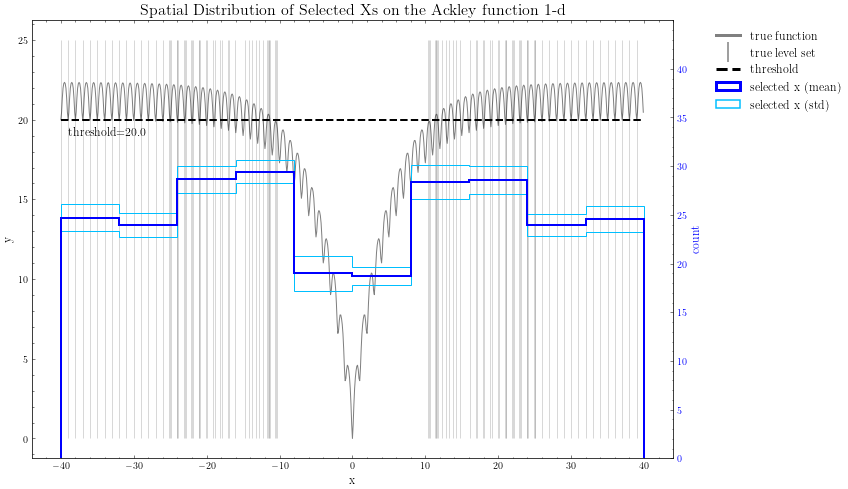

In [15]:
#diagnostic plot
import matplotlib.pyplot as plt
plt.style.use('science')

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
fig, ax1 = plt.subplots(figsize=(12,7))

ax1.set_title('Spatial Distribution of Selected Xs on the Ackley function 1-d', fontsize=16)
ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('y', fontsize=12)

ax1.plot(true_x, true_y, color='black', alpha=0.5, linewidth=1)
ax1.tick_params(axis='y', labelcolor='black')
mask = torch.abs(true_y-threshold) < 0.35
ax1.vlines(true_x[mask],0, 25, alpha=0.3, color='grey')
ax1.hlines(threshold.detach(), -40, 40, color='black', linewidth=2, linestyle='--')
ax1.text(-39,19,f'threshold={threshold.item()}', fontsize=12)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('count', color='blue', fontsize=12)  # we already handled the x-label with ax1
xs = np.array(np.histogram(array[0])[1])


ax2.stairs(count_mean-count_std, xs, color='deepskyblue', linewidth=1 )
ax2.stairs(count_mean+count_std, xs, color='deepskyblue', linewidth=1 )
ax2.stairs(count_mean, xs, color='blue', linewidth=2 )

#ax2.fill_between(xs[:-1], count_mean-count_std, count_mean+count_std, step='pre', color='lightblue', alpha=0.95)

ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim([0,45])
ax2.yaxis.set_ticks(np.arange(0, 45, 5))

legend_elements = [Line2D([0], [0], color='grey', lw=3, label='true function'),
                   Line2D([], [], marker='|', label='true level set', linestyle='None',
                          color='grey', markersize=20, markeredgewidth=1.5),
                Line2D([0], [0], color='black', linestyle='dashed', lw=3, label='threshold'),
                   Patch(facecolor='none', edgecolor='blue',lw=3,
                         label='selected x (mean)'),
                  Patch(facecolor='none', edgecolor='deepskyblue',lw=1.5,
                         label='selected x (std)')]

lgd = plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.savefig('/home/irina/Documents/THESIS/figures/LSE_1D_Ackley_diagnostics.eps')
plt.show()